In [ ]:
# 🔄 Purpose: Fetch latest weekly data for the 5 keywords from Google Trends (weekly granularity only)

from pytrends.request import TrendReq
import pandas as pd
from datetime import date

# Define keywords and timeframe
keywords = ["meditation", "mindfulness", "breathwork", "guided meditation", "yoga nidra"]
today = date.today().strftime("%Y-%m-%d")
timeframe = "today 5-y"

# Initialize pytrends and build payload
pytrends = TrendReq(hl="en-US", tz=360)
pytrends.build_payload(keywords, cat=0, timeframe=timeframe, geo="", gprop="")

# Fetch interest over time
df_weekly = pytrends.interest_over_time()

# Drop 'isPartial' column if it exists
if 'isPartial' in df_weekly.columns:
    df_weekly = df_weekly[~df_weekly['isPartial']]
    df_weekly.drop(columns='isPartial', inplace=True)

# Reshape to long format
df_weekly = df_weekly.reset_index().melt(id_vars=["date"], var_name="keyword", value_name="search_interest")

# Filter for just the most recent week (latest date only)
latest_date = df_weekly["date"].max()
df_latest_week = df_weekly[df_weekly["date"] == latest_date].copy()

# Preview result
print(f"✅ Pulled weekly data for: {latest_date.date()}")
df_latest_week

# 🔄 Purpose: Preview what the dataset will look like after appending new data

# Load the existing dataset
path_existing = "../data/streamlit/global_trend_summary.csv"
df_existing = pd.read_csv(path_existing, parse_dates=["date"])

# Check if this date is already present
latest_date = df_latest_week["date"].iloc[0]
if latest_date in df_existing["date"].unique():
    print(f"⚠️ Date {latest_date.date()} already exists in dataset. Skipping append.")
    df_preview = df_existing.copy()
else:
    # Append new row
    df_preview = pd.concat([df_existing, df_latest_week], ignore_index=True)
    print(f"✅ Appended new week: {latest_date.date()}")

# Sort and preview
df_preview = df_preview.sort_values(["date", "keyword"]).reset_index(drop=True)
df_preview.tail(10)

# ✅ Save the updated global trend dataset using the correct DataFrame
df_preview.to_csv("../data/streamlit/global_trend_summary.csv", index=False)
print("✅ File successfully saved at: ../data/streamlit/global_trend_summary.csv")

In [41]:
# 📊 Diagnostic: Validate global_trend_summary.csv after automation

import pandas as pd

# Load dataset
df = pd.read_csv("../data/streamlit/global_trend_summary.csv", parse_dates=["date"])

# 1. Shape and preview
print("✅ Shape:", df.shape)
display(df.head(3))

# 2. Check column names and dtypes
print("\n📌 Column Info:")
print(df.dtypes)

# 3. Check for nulls or duplicates
print("\n🔍 Null values:\n", df.isnull().sum())
print("\n🧹 Duplicated rows:", df.duplicated().sum())

# 4. Check keyword list
print("\n🧾 Unique keywords:", df['keyword'].unique())

# 5. Check weekly spacing (should be 7 days apart per keyword)
df_sorted = df.sort_values(["keyword", "date"])
df_sorted["gap_days"] = df_sorted.groupby("keyword")["date"].diff().dt.days
print("\n⏱️ Gap check (non-weekly gaps):")
print(df_sorted[df_sorted["gap_days"].notnull() & (df_sorted["gap_days"] != 7)].head())

# 6. Check latest date per keyword
print("\n📆 Latest date by keyword:")
print(df.groupby("keyword")["date"].max())

✅ Shape: (1320, 3)


,date,keyword,search_interest
0,2020-07-26,breathwork,1
1,2020-07-26,guided meditation,6
2,2020-07-26,meditation,90



📌 Column Info:
date               datetime64[ns]
keyword                    object
search_interest             int64
dtype: object

🔍 Null values:
 date               0
keyword            0
search_interest    0
dtype: int64

🧹 Duplicated rows: 0

🧾 Unique keywords: ['breathwork' 'guided meditation' 'meditation' 'mindfulness' 'yoga nidra']

⏱️ Gap check (non-weekly gaps):
Empty DataFrame
Columns: [date, keyword, search_interest, gap_days]
Index: []

📆 Latest date by keyword:
keyword
breathwork          2025-08-10
guided meditation   2025-08-10
meditation          2025-08-10
mindfulness         2025-08-10
yoga nidra          2025-08-10
Name: date, dtype: datetime64[ns]


In [44]:
import pandas as pd

df = pd.read_csv("../data/streamlit/global_trend_summary.csv", parse_dates=["date"])
df.tail(20)

,date,keyword,search_interest
1300,2025-07-20,breathwork,3
1301,2025-07-20,guided meditation,4
1302,2025-07-20,meditation,69
1303,2025-07-20,mindfulness,20
1304,2025-07-20,yoga nidra,3
1305,2025-07-27,breathwork,3
1306,2025-07-27,guided meditation,4
1307,2025-07-27,meditation,69
1308,2025-07-27,mindfulness,19
1309,2025-07-27,yoga nidra,3


In [45]:
df.duplicated(subset=["date", "keyword"]).sum()

np.int64(0)

In [46]:
df[df.duplicated(subset=["date", "keyword"], keep=False)].sort_values("date")

,date,keyword,search_interest


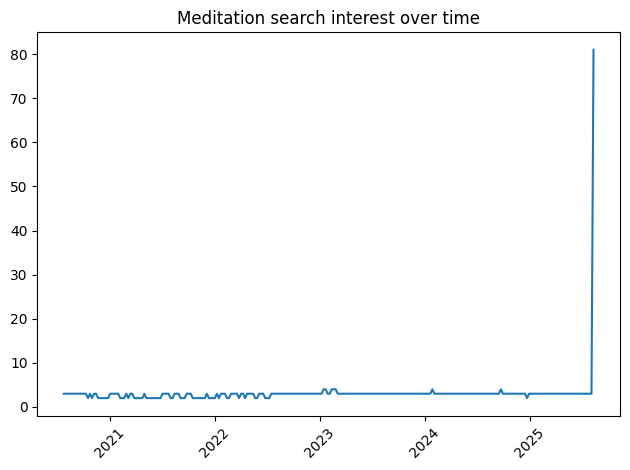

In [48]:
import matplotlib.pyplot as plt

df_meditation = df[df["keyword"] == "yoga nidra"]
plt.plot(df_meditation["date"], df_meditation["search_interest"])
plt.title("Meditation search interest over time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
# Purpose: View the spike row(s) for visual inspection
import pandas as pd

df = pd.read_csv("../data/streamlit/global_trend_summary.csv")
df[df["date"] == "2025-08-10"]

,date,keyword,search_interest
1315,2025-08-10,breathwork,100
1316,2025-08-10,guided meditation,88
1317,2025-08-10,meditation,78
1318,2025-08-10,mindfulness,100
1319,2025-08-10,yoga nidra,81
